In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
import numpy as np

from Newmark import *
from meshes import *
from get_M import *
from get_S import *

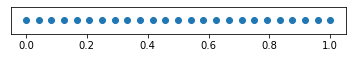

In [2]:
# Spatial resolution of mesh
N = 25

# Right limit of mesh
L = 1

# Generate 1D mesh
[nodes, elems, faces] = get_mesh_1D(N, [0,L], True);
elems = np.array(elems)[:-1,:]          # I believe there is one row too much in elems from get_mesh function

In [3]:
E=1
I=1
mu = 1

In [4]:
M0 = 0
ML = 0
QL = 0
a0 = 0
aL = 0
a = 0
b = 0

q = 1

two_sided_support = True 

if two_sided_support:
    boundary_conditions = {'M0': M0, 'ML': ML, 'a0': a0, 'aL': aL}
else:
    boundary_conditions = {'QL': QL, 'ML': ML, 'a': a, 'b': b}

In [5]:
# get our matices
M_ext = get_extended_M(nodes, elems, mu, two_sided_support)
S_ext = get_extended_S(nodes, elems, E, I, two_sided_support)
# get RHS with load
rhs1 = get_extended_q_vector(nodes, elems, q, boundary_conditions, two_sided_support)
# a load vector for zero load
zeroRHS = get_extended_q_vector(nodes, elems, 0, boundary_conditions, two_sided_support)


# get FEM solution, which we use as initial condition for the Newmark method with a different load
solution = spsolve(S_ext, rhs1)
# at t=t1 we initialize up1 and upp1 as zeros. (why?)
up1 = np.zeros((np.shape(solution)))
upp1 = np.zeros((np.shape(solution)))

# note u1 also contains the derivative wrt x

#initialize class for newmark iteration. 
# in this case we set the load vector to zero to see what happens. Of course one can also choose a different load. 
# note if the load is equal to the load for which u1 is computed then we are already in a stationary point and there
# is no movement
new = Newmark(u1=solution, up1=up1, upp1=upp1, h=0.01, beta=1/4, gamma=1/2, Me=M_ext, Se=S_ext, f=zeroRHS)

# the number of time steps
tsteps=200
# run the newmark iteration
new.run(tsteps)
results = new.results

C:\Users\sergi\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [6]:
u = results["u"]

def sol_step(u, i):
    """ 
    Function to separate derivative and solution 
    """
    u = u[i]
    u = u[:-2]
    ux = u[::2]
    
    return ux


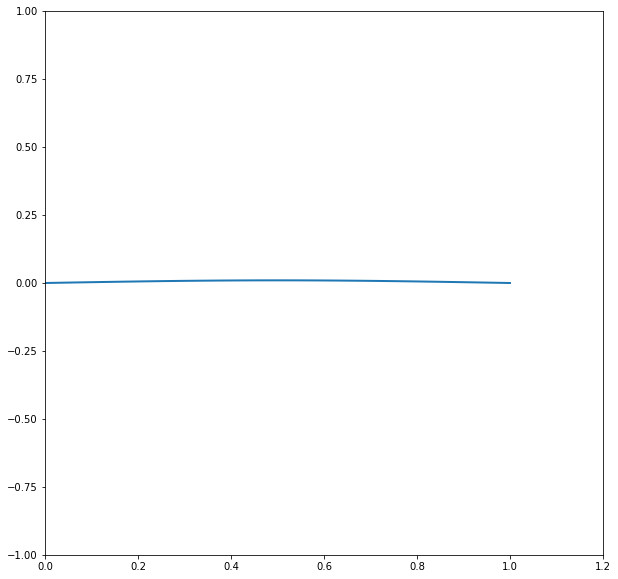

In [7]:
# get animations

%matplotlib inline

from matplotlib import animation, rc
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(10,10))

ax.set_xlim(( 0, 1.2))
ax.set_ylim((-1,1))
# try: ax.set_ylim((np.min(-u[nsteps-1][:-2][::2]), np.max(u[nsteps-1][:-2][::2])))
# except: ax.set_ylim((np.min(-solution), np.max(solution)))
        
line, = ax.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return (line,)

def animate(i):
    line.set_data(nodes, sol_step(u, i))
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=tsteps, interval=10, 
                               blit=True)
HTML(anim.to_jshtml())